In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from hurst import compute_Hc
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

import warnings
warnings.filterwarnings('ignore')

C:\Users\jackm\AppData\Local\Temp\ipykernel_7036\3772738219.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [2]:
print("########################## WARNING: USED ffill WITHOUT REVIEWING DATA NOT READY FOR PROD ######################################")

########################## WARNING: USED ffill WITHOUT REVIEWING DATA NOT READY FOR PROD ######################################


In [3]:
print("######################### WARNING: NEED TO GIVE MANUAL REVIEW OF TEST DATA TO CONFIRM ALL CALCULATIONS ARE CORRECT AND BACKTEST BEHAVES AS EXPECTED.")

######################### WARNING: NEED TO GIVE MANUAL REVIEW OF TEST DATA TO CONFIRM ALL CALCULATIONS ARE CORRECT AND BACKTEST BEHAVES AS EXPECTED.


In [4]:
indicies = ['^FTSE', '^FTAI']

In [5]:
data = yf.download(indicies, start='2021-01-01')

[*********************100%***********************]  2 of 2 completed


In [6]:
data = data['Adj Close']

In [7]:
data.index = pd.to_datetime(data.index)

In [8]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(data.isna().sum())
    print(data[data.isnull().any(axis=1)])

^FTAI    14
^FTSE     0
dtype: int64
            ^FTAI        ^FTSE
Date                          
2021-01-04    NaN  6571.899902
2021-01-22    NaN  6695.100098
2021-01-28    NaN  6526.200195
2021-02-15    NaN  6756.100098
2021-02-17    NaN  6710.899902
2021-03-03    NaN  6675.500000
2021-03-12    NaN  6761.500000
2021-05-05    NaN  7039.299805
2021-05-11    NaN  6948.000000
2021-05-25    NaN  7029.799805
2021-06-10    NaN  7088.200195
2021-07-05    NaN  7164.899902
2021-07-26    NaN  7025.399902
2021-08-09    NaN  7132.299805


In [9]:
data.fillna(method='ffill', inplace=True)

In [10]:
data_weekly = data.asfreq('w', method='ffill')

In [11]:
data_weekly['Prev 2 week returns FTAI'] = data_weekly['^FTAI'].pct_change(2)

In [12]:
data_weekly['Prev 2 week returns FTSE'] = data_weekly['^FTSE'].pct_change(2)

In [13]:
#data_weekly = data_weekly.iloc[2:]

In [14]:
data_weekly

,^FTAI,^FTSE,Prev 2 week returns FTAI,Prev 2 week returns FTSE
Date,,,,
2021-01-10,1179.760010,6873.299805,NaN,NaN
2021-01-17,1173.119995,6735.700195,NaN,NaN
2021-01-24,1198.089966,6695.100098,0.015537,-0.025926
2021-01-31,1160.670044,6407.500000,-0.010613,-0.048725
2021-02-07,1211.579956,6489.299805,0.011260,-0.030739
...,...,...,...,...
2023-05-07,828.789978,7778.399902,-0.001819,-0.017147
2023-05-14,816.960022,7754.600098,-0.015640,-0.014738
2023-05-21,808.969971,7756.899902,-0.023914,-0.002764


In [15]:
data_weekly['FTSE positions'] = np.where(data_weekly['Prev 2 week returns FTSE'] > 0, 1, 0)

In [16]:
data_weekly['FTAI positions'] = np.where(data_weekly['Prev 2 week returns FTAI'] > 0, 0, -1)

In [17]:
data_weekly['FTSE Next week returns'] = data_weekly['^FTSE'].pct_change(1).shift(-1)

In [18]:
data_weekly['FTAI Next week returns'] = data_weekly['^FTAI'].pct_change(1).shift(-1)

In [19]:
data_weekly['strategy_returns'] = (data_weekly['FTSE positions'] * data_weekly['FTSE Next week returns']) + (data_weekly['FTAI positions'] * data_weekly['FTAI Next week returns'])

In [20]:
data_weekly['strat_cum_returns'] = (data_weekly['strategy_returns']+1).cumprod()

In [21]:
data_weekly['strat_cum_returns']

Date
2021-01-10    1.005628
2021-01-17    0.984223
2021-01-24    0.984223
2021-01-31    0.941053
2021-02-07    0.941053
                ...   
2023-05-07    1.754487
2023-05-14    1.771647
2023-05-21    1.809446
2023-05-28    1.814314
2023-06-04         NaN
Freq: W-SUN, Name: strat_cum_returns, Length: 126, dtype: float64

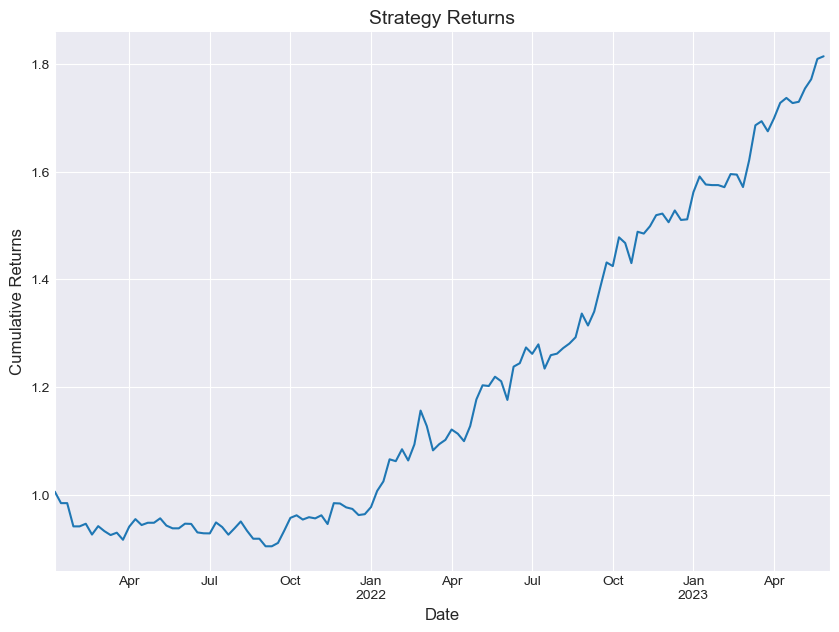

In [22]:
data_weekly['strat_cum_returns'].plot(figsize=(10, 7))
# Set title and labels for the plot
plt.title('Strategy Returns', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)
plt.show()

The maximum drawdown is -10.10


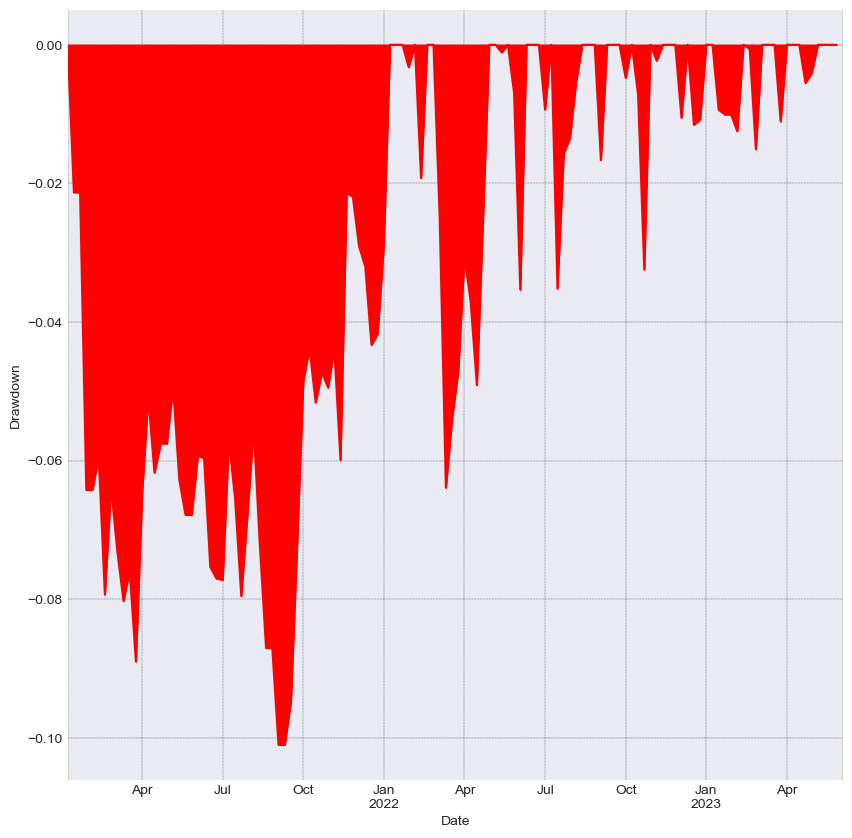

In [23]:
running_max = np.maximum.accumulate(data_weekly['strat_cum_returns'].dropna())
running_max[running_max < 1] = 1
# Calculate the percentage drawdown
drawdown = (data_weekly['strat_cum_returns'])/running_max - 1
max_dd = drawdown.min()*100
print('The maximum drawdown is %.2f' % max_dd)
# Plot the drawdowns
drawdown.plot(color='r',figsize=(10,10))
plt.ylabel('Drawdown')
plt.fill_between(drawdown.index, drawdown, color='red')
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
plt.show()


In [24]:
###################### Long returns #################################
data_weekly['long_FTSE_cum_returns'] = np.where(data_weekly['FTSE positions'] == 1, data_weekly['FTSE positions'] * data_weekly['FTSE Next week returns'], 0)
data_weekly['long_FTSE_cum_returns'] = (data_weekly['long_FTSE_cum_returns'] + 1).cumprod()

In [25]:
###################### Short returns #################################
data_weekly['short_FTAI_cum_returns'] = np.where(data_weekly['FTAI positions'] == -1, data_weekly['FTAI positions'] * data_weekly['FTAI Next week returns'], 0)
data_weekly['short_FTAI_cum_returns'] = (data_weekly['short_FTAI_cum_returns'] + 1).cumprod()

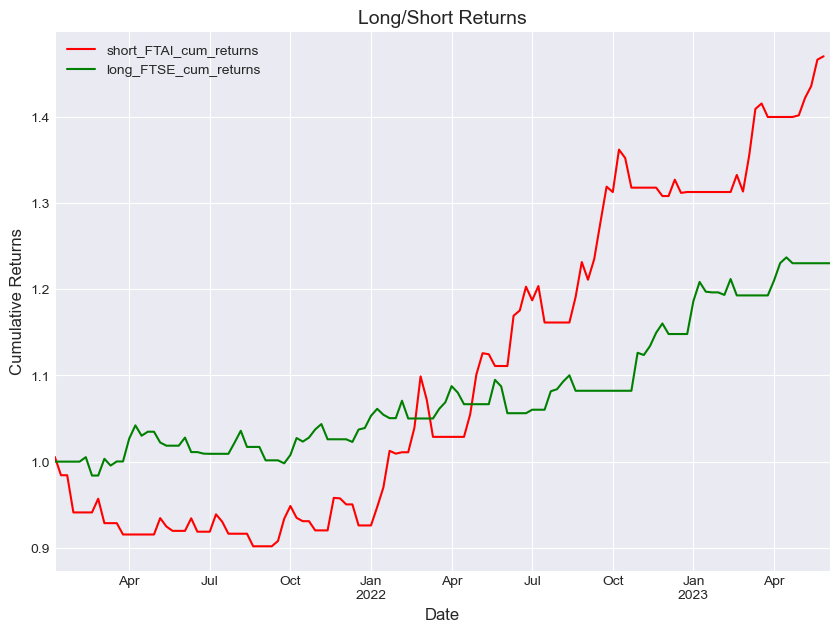

In [26]:
data_weekly['short_FTAI_cum_returns'].plot(figsize=(10, 7), color='r')
data_weekly['long_FTSE_cum_returns'].plot(figsize=(10, 7), color='g')
# Set title and labels for the plot
plt.title('Long/Short Returns', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)
plt.legend()
plt.show()

In [219]:
data_weekly[-20:]

,^FTAI,^FTSE,Prev 2 week returns FTAI,Prev 2 week returns FTSE,FTSE positions,FTAI positions,FTSE Next week returns,FTAI Next week returns,strategy_returns,strat_cum_returns,long_FTSE_cum_returns,short_FTAI_cum_returns
Date,,,,,,,,,,,,
2023-01-22,856.020020,7770.600098,0.010101,0.009234,1,0,-0.000695,0.015444,-0.000695,1.575017,1.196404,1.312917
2023-01-29,869.239990,7765.200195,0.005367,-0.010059,0,0,0.017591,0.023641,0.000000,1.575017,1.196404,1.312917
2023-02-05,889.789978,7901.799805,0.039450,0.016884,1,0,-0.002442,-0.017307,-0.002442,1.571170,1.193481,1.312917
2023-02-12,874.390015,7882.500000,0.005925,0.015106,1,0,0.015465,-0.009938,0.015465,1.595468,1.211938,1.312917
2023-02-19,865.700012,8004.399902,-0.027074,0.012984,1,-1,-0.015704,-0.015098,-0.000606,1.594501,1.192906,1.332739
2023-02-26,852.630005,7878.700195,-0.024886,-0.000482,0,-1,0.008682,0.014473,-0.014473,1.571424,1.192906,1.313450
2023-03-05,864.969971,7947.100098,-0.000843,-0.007159,0,-1,-0.025003,-0.031828,0.031828,1.621439,1.192906,1.355254
2023-03-12,837.440002,7748.399902,-0.017815,-0.016538,0,-1,-0.053301,-0.039895,0.039895,1.686127,1.192906,1.409323
2023-03-19,804.030029,7335.399902,-0.070453,-0.076971,0,-1,0.009556,-0.004490,0.004490,1.693697,1.192906,1.415651
